In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core import display as ICD
import seaborn as sns
import glob
import scipy
import os
pd.set_option('display.max_columns', 100)

In [2]:
# import scikit learn packages

from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

from sklearn.pipeline import make_pipeline

In [3]:
DATA_FOLDER = './data_extractor_scripts/'

### Regression matrix manipulation

Here we are going to handle the albedo case if needed

In [ ]:
# tot_df[tot_df['Albedo [-]']==-np.inf]
#tot_df.index[np.isinf(tot_df).any(1)]
#tot_df.columns.to_series()[np.isinf(tot_df).any()]
#plt.plot(tot_df['Albedo [-]'].drop(np.inf))
#tot_df[~tot_df.isin([np.inf, -np.inf]).any(1)]['Albedo [-]'].plot()

Importing regression matrix

In [4]:
tot_df=pd.read_csv(DATA_FOLDER+'regression_mat_year.csv',index_col=0)

In [5]:
tot_df

,direction,u,u_z,sonic_temp,h,direction_top,u_top,u_top_z,sonic_temp_top,Pyranometer Upper Irradiance [W/m$^2$],Pyranometer Lower Irradiance [W/m$^2$],Pyrgeometer Upper Irradiance [W/m$^2$],Pyrgeometer Lower Irradiance [W/m$^2$],Net Solar radiation [W/m$^2$],Net (total) radiation [W/m$^2$],Net Far Infrared radiation [W/m$^2$],Sky temperature [°C],Radiometer Ground temperature [°C],Sensor Ground temperature [°C],North temperature [°C],East temperature [°C],South temperature [°C],West temperature [°C]
2018-01-01 00:00:00,173.754960,1.248561,-0.015407,12.275946,1.5,275.113958,7.281966,-0.659382,11.976841,2.722102,0.884044,357.221397,353.201172,1.838058,5.858282,4.020225,8.578522,7.784829,7.816388,6.241472,11.404682,10.281940,8.124415
2018-01-01 00:00:00,236.830532,2.035754,-0.330108,11.766161,5.5,275.113958,7.281966,-0.659382,11.976841,2.722102,0.884044,357.221397,353.201172,1.838058,5.858282,4.020225,8.578522,7.784829,7.816388,6.241472,11.404682,10.281940,8.124415
2018-01-01 00:00:00,272.498844,3.906485,-0.491298,11.000631,9.5,275.113958,7.281966,-0.659382,11.976841,2.722102,0.884044,357.221397,353.201172,1.838058,5.858282,4.020225,8.578522,7.784829,7.816388,6.241472,11.404682,10.281940,8.124415
2018-01-01 00:00:00,282.630634,5.502737,-0.530402,11.785795,13.5,275.113958,7.281966,-0.659382,11.976841,2.722102,0.884044,357.221397,353.201172,1.838058,5.858282,4.020225,8.578522,7.784829,7.816388,6.241472,11.404682,10.281940,8.124415
2018-01-01 00:00:00,279.706713,6.305754,-0.780546,11.898535,17.5,275.113958,7.281966,-0.659382,11.976841,2.722102,0.884044,357.221397,353.201172,1.838058,5.858282,4.020225,8.578522,7.784829,7.816388,6.241472,11.404682,10.281940,8.124415
2018-01-01 00:00:00,284.943350,6.811323,-0.669650,11.325203,21.5,275.113958,7.281966,-0.659382,11.976841,2.722102,0.884044,357.221397,353.201172,1.838058,5.858282,4.020225,8.578522,7.784829,7.816388,6.241472,11.404682,10.281940,8.124415
2018-01-01 00:05:00,197.134383,0.827382,-0.005294,11.620777,1.5,279.388248,4.008132,-0.069338,11.384703,0.760311,0.747337,358.259501,352.690308,0.012975,5.582167,5.569192,8.783513,7.682283,7.979000,6.678000,11.257667,9.575333,7.475667
2018-01-01 00:05:00,232.638222,1.151649,-0.153743,11.169077,5.5,279.388248,4.008132,-0.069338,11.384703,0.760311,0.747337,358.259501,352.690308,0.012975,5.582167,5.569192,8.783513,7.682283,7.979000,6.678000,11.257667,9.575333,7.475667
2018-01-01 00:05:00,277.977653,2.197105,-0.368429,10.344776,9.5,279.388248,4.008132,-0.069338,11.384703,0.760311,0.747337,358.259501,352.690308,0.012975,5.582167,5.569192,8.783513,7.682283,7.979000,6.678000,11.257667,9.575333,7.475667
2018-01-01 00:05:00,286.255949,3.046184,-0.263554,11.174527,13.5,279.388248,4.008132,-0.069338,11.384703,0.760311,0.747337,358.259501,352.690308,0.012975,5.582167,5.569192,8.783513,7.682283,7.979000,6.678000,11.257667,9.575333,7.475667


Transform absolute value and direction in vector components

In [6]:
# create columns with coordinate velocities output
tot_df['u_x']=tot_df['u']*np.cos(np.radians(tot_df['direction']))
tot_df['u_y']=tot_df['u']*np.sin(np.radians(tot_df['direction']))

In [7]:
# create columns with coordinate velocities input top mast anemometer
tot_df['u_top_x']=tot_df['u_top']*np.cos(np.radians(tot_df['direction_top']))
tot_df['u_top_y']=tot_df['u_top']*np.sin(np.radians(tot_df['direction_top']))

In [8]:
# drop the columns which are not used anymore
tot_df=tot_df.drop(columns=['u', 'u_top', 'direction', 'direction_top'])

In [9]:
tot_df

,u_z,sonic_temp,h,u_top_z,sonic_temp_top,Pyranometer Upper Irradiance [W/m$^2$],Pyranometer Lower Irradiance [W/m$^2$],Pyrgeometer Upper Irradiance [W/m$^2$],Pyrgeometer Lower Irradiance [W/m$^2$],Net Solar radiation [W/m$^2$],Net (total) radiation [W/m$^2$],Net Far Infrared radiation [W/m$^2$],Sky temperature [°C],Radiometer Ground temperature [°C],Sensor Ground temperature [°C],North temperature [°C],East temperature [°C],South temperature [°C],West temperature [°C],u_x,u_y,u_top_x,u_top_y
2018-01-01 00:00:00,-0.015407,12.275946,1.5,-0.659382,11.976841,2.722102,0.884044,357.221397,353.201172,1.838058,5.858282,4.020225,8.578522,7.784829,7.816388,6.241472,11.404682,10.281940,8.124415,-1.241152,0.135820,0.649092,-7.252979
2018-01-01 00:00:00,-0.330108,11.766161,5.5,-0.659382,11.976841,2.722102,0.884044,357.221397,353.201172,1.838058,5.858282,4.020225,8.578522,7.784829,7.816388,6.241472,11.404682,10.281940,8.124415,-1.113796,-1.704040,0.649092,-7.252979
2018-01-01 00:00:00,-0.491298,11.000631,9.5,-0.659382,11.976841,2.722102,0.884044,357.221397,353.201172,1.838058,5.858282,4.020225,8.578522,7.784829,7.816388,6.241472,11.404682,10.281940,8.124415,0.170320,-3.902771,0.649092,-7.252979
2018-01-01 00:00:00,-0.530402,11.785795,13.5,-0.659382,11.976841,2.722102,0.884044,357.221397,353.201172,1.838058,5.858282,4.020225,8.578522,7.784829,7.816388,6.241472,11.404682,10.281940,8.124415,1.203256,-5.369571,0.649092,-7.252979
2018-01-01 00:00:00,-0.780546,11.898535,17.5,-0.659382,11.976841,2.722102,0.884044,357.221397,353.201172,1.838058,5.858282,4.020225,8.578522,7.784829,7.816388,6.241472,11.404682,10.281940,8.124415,1.063181,-6.215479,0.649092,-7.252979
2018-01-01 00:00:00,-0.669650,11.325203,21.5,-0.659382,11.976841,2.722102,0.884044,357.221397,353.201172,1.838058,5.858282,4.020225,8.578522,7.784829,7.816388,6.241472,11.404682,10.281940,8.124415,1.756394,-6.580973,0.649092,-7.252979
2018-01-01 00:05:00,-0.005294,11.620777,1.5,-0.069338,11.384703,0.760311,0.747337,358.259501,352.690308,0.012975,5.582167,5.569192,8.783513,7.682283,7.979000,6.678000,11.257667,9.575333,7.475667,-0.790659,-0.243758,0.653821,-3.954446
2018-01-01 00:05:00,-0.153743,11.169077,5.5,-0.069338,11.384703,0.760311,0.747337,358.259501,352.690308,0.012975,5.582167,5.569192,8.783513,7.682283,7.979000,6.678000,11.257667,9.575333,7.475667,-0.698874,-0.915353,0.653821,-3.954446
2018-01-01 00:05:00,-0.368429,10.344776,9.5,-0.069338,11.384703,0.760311,0.747337,358.259501,352.690308,0.012975,5.582167,5.569192,8.783513,7.682283,7.979000,6.678000,11.257667,9.575333,7.475667,0.304929,-2.175842,0.653821,-3.954446
2018-01-01 00:05:00,-0.263554,11.174527,13.5,-0.069338,11.384703,0.760311,0.747337,358.259501,352.690308,0.012975,5.582167,5.569192,8.783513,7.682283,7.979000,6.678000,11.257667,9.575333,7.475667,0.852714,-2.924400,0.653821,-3.954446


### Splitting Data

In [10]:
X = np.array(tot_df.drop(columns=['u_x', 'u_y','u_z']))
y = np.array(tot_df[['u_x', 'u_y']])

In [11]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
y_tr[:,1].mean()

-0.11079297602767736

### Anemometer splitting of test

In [14]:
h=np.arange(1.5,22,4)
X_te_hs=[]
y_te_hs=[]
for i in h:
    X_te_hs.append(X_te[X_te[:,1]==i])
    y_te_hs.append(y_te[X_te[:,1]==i])

In [15]:
print(X_te_hs[2].shape)
print(y_te_hs[2].shape)

(26834, 20)
(26834, 2)


### Regression

In [19]:
#plot functions
def plot_ys(y_pred,y_te,interval=[100,200]):
    
    for idx,i in enumerate(y_pred):

        fig=plt.figure(figsize=(16,12))

        plt.subplot(221)
        plt.gca().set_title('u_x')
        plt.plot(i[interval[0]:interval[1],0],'r-',label='u_x_pred')
        plt.plot(y_te[idx][interval[0]:interval[1],0],'b-',label='u_x_test')
        plt.xlabel('t')
        plt.ylabel('u_x')
        plt.legend()

        plt.subplot(222)
        plt.gca().set_title('u_y')
        plt.plot(i[interval[0]:interval[1],1],'r-',label='u_y_pred')
        plt.plot(y_te[idx][interval[0]:interval[1],1],'b-',label='u_y_test')
        plt.xlabel('t')
        plt.ylabel('u_y')
        plt.legend()

        plt.show()

Optimize the ridge regression parameter

In [ ]:
alphas=np.logspace(-1,10,100)

#leave one out method is used
clf_cv = RidgeCV(alphas, cv=None, store_cv_values=True)
clf_cv.fit(X_tr, y_tr) 

# number of datapoints, number of targets, number of alphas
# it already contains the mse
mse_all_folds=clf_cv.cv_values_
mse_means=np.mean(mse_all_folds, axis=0)
ax=plt.gca()
u_x,=ax.plot(alphas,mse_means[0],'r-',label='MSE u_x')
u_y,=ax.plot(alphas,mse_means[1],'b-',label='MSE u_y')
plt.xscale('log')
plt.xlabel('Alphas')
plt.ylabel('MSE')
ax.legend()

Optimize the ridge regression parameter with standardization

In [ ]:
alphas=np.logspace(-1,10,100)

#stadardize the data

scaler = StandardScaler()
#define mean and standard based on the test data
scaler.fit(X_tr)
X_tr_scaled=scaler.transform(X_tr)
X_te_scaled=scaler.transform(X_te)


#leave one out method is used
clf_cv = RidgeCV(alphas, cv=None, store_cv_values=True)
clf_cv.fit(X_tr_scaled, y_tr) 

# number of datapoints, number of targets, number of alphas
# it already contains the mse
mse_all_folds=clf_cv.cv_values_
mse_means=np.mean(mse_all_folds, axis=0)
ax=plt.gca()

u_x_mse_train,=ax.plot(alphas,mse_means[0],'r-',label='MSE u_x train')
u_y_mse_train,=ax.plot(alphas,mse_means[1],'b-',label='MSE u_y train')
u_mean_mse_train,=ax.plot(alphas,np.mean(mse_means, axis=0),'g-',label='MSE u mean train')

mse_u_test=[]

for alpha in alphas:
    
    clf = Ridge(alpha)
    clf.fit(X_tr_scaled, y_tr) 
    mse_u_test.append(mean_squared_error(y_te,clf.predict(X_te_scaled)))

u_mse_test,=ax.plot(alphas,mse_u_test,'g--',label='MSE u mean test')

plt.xscale('log')
plt.xlabel('Alphas')
plt.ylabel('MSE')
ax.legend()

In [ ]:
plot_ys(clf_cv.predict(X_te_scaled),y_te)

Optimize the ridge regression parameter with standardization and polynomial feature expansion

In [16]:
alphas=np.logspace(-10,10,100)
degree=2

#define pipeline
model = make_pipeline(StandardScaler(),PolynomialFeatures(degree), RidgeCV(alphas))

model.fit(X_tr,y_tr)
y_pred_hs=[]
for hs in X_te_hs:
    y_pred_hs.append(model.predict(hs))

In [17]:
mses=[]
for idx,i in enumerate(y_pred_hs):
    mses.append(mean_squared_error(y_te_hs[idx],i))
print(mses)

[0.17919674000169575, 0.17305237351618413, 0.29056024166494765, 0.6153605863509657, 0.5902710060569232, 1.1635932132304188]


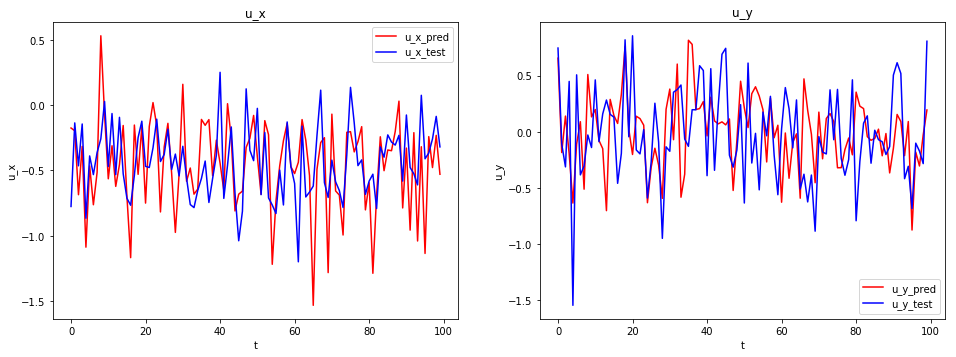

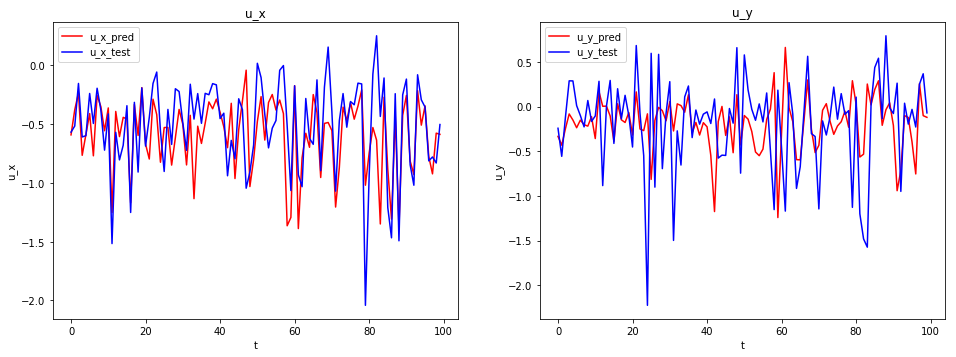

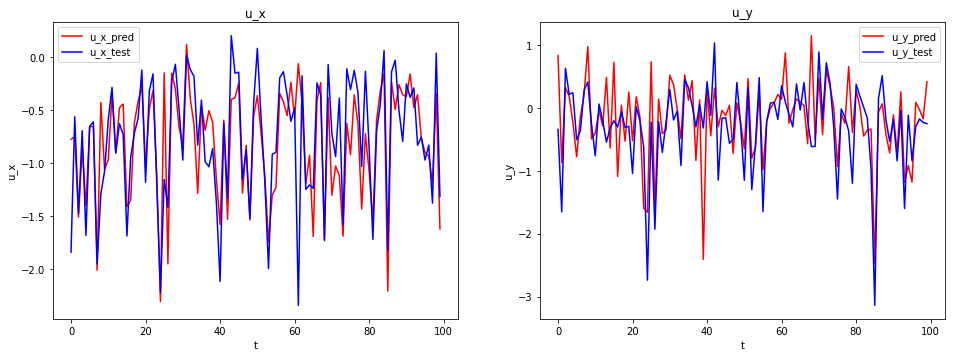

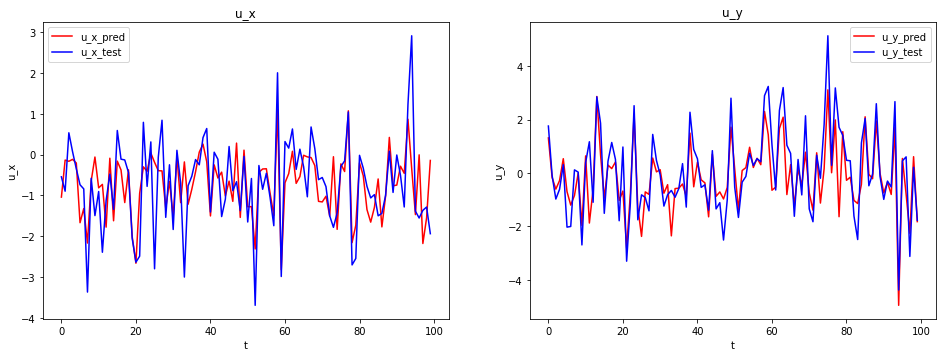

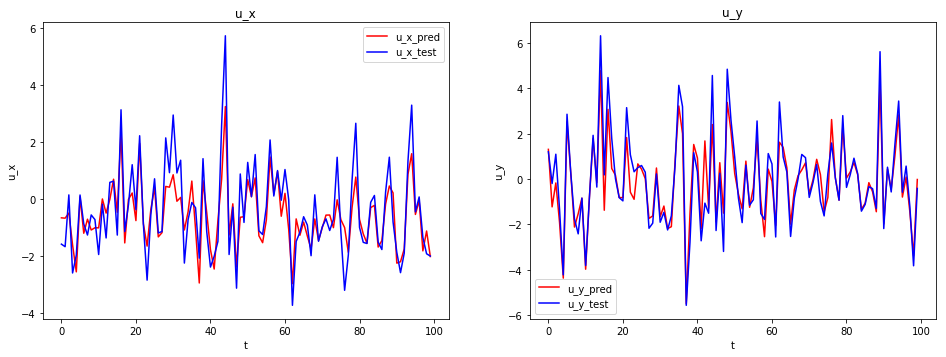

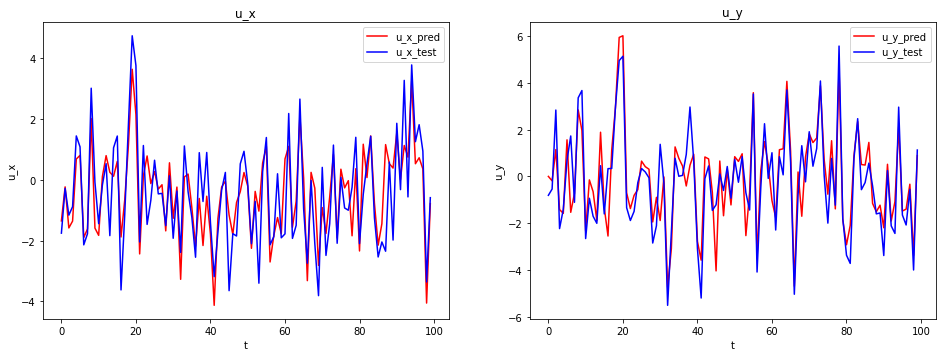

In [20]:
plot_ys(y_pred_hs,y_te_hs,[500,600])

Ridge regression with PCA

In [ ]:
alphas=np.logspace(-10,10,100)

#define pipeline
model = make_pipeline(PCA(n_components = 3), RidgeCV(alphas))

model.fit(X_tr,y_tr)
y_pred4 = model.predict(X_te)

mse = mean_squared_error(y_te,y_pred4)
mse
#0.31212712287932676

In [ ]:
plot_ys(y_pred4,y_te)

Get the mean squared error